## Importing the libraries

In [44]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.stem.snowball import SnowballStemmer
import re, string
import time
import warnings
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline


%matplotlib inline

## Creating our DataFrame

### There are 49 columns in our dataset combined. To create feature vector, we do not need all columns. Hence, we drop the columns which are not useful for prediction.

### Importing the Comments file into dataframes and then concatinating into a single dataframe to work with.

In [45]:
warnings.simplefilter('ignore')

dfReqColumnComment=['articleID', 'createDate', 'approveDate', 'commentBody', 'recommendations', 'replyCount','editorsSelection']

#Importing Comments
df1=pd.read_csv("D:\BigData Project\CommentsJan2017.csv",usecols=dfReqColumnComment)
df2=pd.read_csv("D:\BigData Project\CommentsFeb2017.csv",usecols=dfReqColumnComment)
df3=pd.read_csv("D:\BigData Project\CommentsMarch2017.csv",usecols=dfReqColumnComment)
df4=pd.read_csv("D:\BigData Project\CommentsApril2017.csv",usecols=dfReqColumnComment)
df5=pd.read_csv("D:\BigData Project\CommentsMay2017.csv",usecols=dfReqColumnComment)
df6=pd.read_csv("D:\BigData Project\CommentsJan2018.csv",usecols=dfReqColumnComment)
df7=pd.read_csv("D:\BigData Project\CommentsFeb2018.csv",usecols=dfReqColumnComment)
df8=pd.read_csv("D:\BigData Project\CommentsMarch2018.csv",usecols=dfReqColumnComment)
df9=pd.read_csv("D:\BigData Project\CommentsApril2018.csv",usecols=dfReqColumnComment)

#Concatinating into a single dataframe
dfComments=pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])


In [57]:
dfComments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2176364 entries, 0 to 264923
Data columns (total 7 columns):
approveDate         int64
articleID           object
commentBody         object
createDate          float64
editorsSelection    int64
recommendations     float64
replyCount          float64
dtypes: float64(3), int64(2), object(2)
memory usage: 132.8+ MB


### Importing the Articles file into dataframes and then concatinating into a single dataframe to work with.

In [46]:
dfReqColumnArticle = ['articleID', 'articleWordCount', 'newDesk', 'typeOfMaterial', 'pubDate']

#Importing Articles 
df1 = pd.read_csv('D:\BigData Project\ArticlesJan2017.csv',usecols=dfReqColumnArticle)
df2 = pd.read_csv('D:\BigData Project\ArticlesFeb2017.csv',usecols=dfReqColumnArticle)
df3 = pd.read_csv('D:\BigData Project\ArticlesMarch2017.csv',usecols=dfReqColumnArticle)
df4 = pd.read_csv('D:\BigData Project\ArticlesApril2017.csv',usecols=dfReqColumnArticle)
df5 = pd.read_csv('D:\BigData Project\ArticlesMay2017.csv',usecols=dfReqColumnArticleb)
df6 = pd.read_csv('D:\BigData Project\ArticlesJan2018.csv',usecols=dfReqColumnArticle)
df7 = pd.read_csv('D:\BigData Project\ArticlesFeb2018.csv',usecols=dfReqColumnArticle)
df8 = pd.read_csv('D:\BigData Project\ArticlesMarch2018.csv',usecols=dfReqColumnArticle)
df9 = pd.read_csv('D:\BigData Project\ArticlesApril2018.csv',usecols=dfReqColumnArticle)

#Concatinating into a single dataframe
dfArticles=pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])


In [58]:
dfArticles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9335 entries, 0 to 1323
Data columns (total 5 columns):
articleID           9335 non-null object
articleWordCount    9335 non-null int64
newDesk             9335 non-null object
pubDate             9335 non-null object
typeOfMaterial      9335 non-null object
dtypes: int64(1), object(4)
memory usage: 437.6+ KB


### Creating a single merged Dataframe

In [47]:
df = pd.merge(dfArticles, dfComments, on='articleID', how='inner')

### Previewing our data

In [48]:
df.head(5)

,articleID,articleWordCount,newDesk,pubDate,typeOfMaterial,approveDate,commentBody,createDate,editorsSelection,recommendations,replyCount
0,58691a5795d0e039260788b9,1324,National,2017-01-01 15:03:38,News,1483455908,For all you Americans out there --- still rejo...,1.483426e+09,0,5.0,0.0
1,58691a5795d0e039260788b9,1324,National,2017-01-01 15:03:38,News,1483455656,Obamas policies may prove to be the least of t...,1.483417e+09,0,3.0,0.0
2,58691a5795d0e039260788b9,1324,National,2017-01-01 15:03:38,News,1483455655,Democrats are comprised of malcontents who gen...,1.483431e+09,0,3.0,0.0
3,58691a5795d0e039260788b9,1324,National,2017-01-01 15:03:38,News,1483455653,The picture in this article is the face of con...,1.483419e+09,0,3.0,0.0
4,58691a5795d0e039260788b9,1324,National,2017-01-01 15:03:38,News,1483455216,Elections have consequences.,1.483417e+09,0,3.0,0.0


### The target column is 'editorsSelection'. Let's have a look at that

In [49]:
df.editorsSelection.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: editorsSelection, dtype: int64

# Pre-Processing Data

### The comments provided by the users could contain a lot of errors. Hence, we need to remove them and filter the records.

### Removing wrong encoding 

In [50]:
df.commentBody = df.commentBody.apply(lambda x: str(x.encode('ascii', 'ignore')))

### Removing HTML tags

In [51]:
def removeTags(text):
    tags = re.compile(r'<[^>]+>')
    return tags.sub('', text)

df.commentBody = df.commentBody.apply(lambda x: removeTags(x))

### Removing punctuations

In [52]:
def removePunctuation(text):
    tags=re.compile(r'[^\w\s]')
    return tags.sub(' ',text)

df.commentBody = df.commentBody.apply(lambda x: removePunctuation(x))

### Processing important Names and Entities

In [53]:
#The purpose of this function is to find out important Names and Entitites in our dataset. For example it should not 
#classify 'Barack Obama' as just a word


def NER(df):
    continuous_chunk = []
    for index, row in df.iterrows():
        chunked = ne_chunk(pos_tag(word_tokenize(row['commentBody']))) #ne_chunk splits the comment body based on Name or entity
        prev = None
        current_chunk = []
        for i in chunked:
            if type(i) == Tree:
                current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            elif current_chunk:
                named_entity = " ".join(current_chunk)
                if named_entity not in continuous_chunk:
                    continuous_chunk.append(named_entity)
                    current_chunk = []
                else:
                    continue
    return set(continuous_chunk)

#peopleWords= NER(df[df['editorsSelection'] == 1])

#pickle_out=open("dict.pickle","wb")
#pickle.dump(peopleWords,pickle_out)
#pickle_out.close()

pickle_in=open("dict.pickle","rb")
peopleWords=pickle.load(pickle_in)


In [54]:
words = set(nltk.corpus.words.words() + list(nltk.corpus.wordnet.words()) + list(peopleWords))



### Tokenizing and then lemmatization of the word

In [55]:
def cleanText(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words or w.lower() in words or (nltk.corpus.wordnet.morphy(w.lower()) is not None and nltk.corpus.wordnet.morphy(w.lower()).lower() in words))


#df.commentBody = df.commentBody.apply(lambda x: cleanText(x))

#pickle_out=open("dict2.pickle","wb")
#pickle.dump(df.commentBody,pickle_out)
#pickle_out.close()

pickle_in=open("dict2.pickle","rb")
peopleWords=pickle.load(pickle_in)



In [56]:
#Converting the columns into approriate format
df['commentApprovalLength'] = df.apply(lambda row: (dt.datetime.fromtimestamp(int(row['approveDate'])) - dt.datetime.fromtimestamp(int(row['createDate']))).total_seconds(), axis=1)
df['commentPubLength'] = df.apply(lambda row: (dt.datetime.fromtimestamp(int(row['approveDate'])) - dt.datetime.strptime(row['pubDate'], '%Y-%m-%d %H:%M:%S')).total_seconds(), axis=1)
#df['commentWordCount'] = df.apply(lambda row: sum(Counter(row['commentBody'].split()).values()), axis=1)

In [59]:
df.drop(columns=['approveDate', 'createDate', 'articleID', 'pubDate'], inplace=True)

### Encoding the columns 

In [60]:
df = pd.get_dummies(df, columns=["newDesk", "typeOfMaterial"])

In [61]:
df.head(10)

,articleWordCount,commentBody,editorsSelection,recommendations,replyCount,commentApprovalLength,commentPubLength,newDesk_Arts&Leisure,newDesk_Automobiles,newDesk_BookReview,...,typeOfMaterial_Editorial,typeOfMaterial_Interview,typeOfMaterial_Letter,typeOfMaterial_News,typeOfMaterial_News Analysis,typeOfMaterial_Obituary (Obit),typeOfMaterial_Op-Ed,typeOfMaterial_Question,typeOfMaterial_Review,typeOfMaterial_briefing
0,1324,b For all you Americans out there still re...,0,5.0,0.0,29803.0,151290.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1324,b Obamas policies may prove to be the least of...,0,3.0,0.0,38249.0,151038.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1324,b Democrats are comprised of malcontents who g...,0,3.0,0.0,24222.0,151037.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1324,b The picture in this article is the face of c...,0,3.0,0.0,36800.0,151035.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1324,b Elections have consequences,0,3.0,0.0,38450.0,150598.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1324,b Shakespeare showed us that appetite brings...,0,9.0,0.0,236.0,111322.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,1324,b Obama Policies Are in Peril as New Congress...,0,5.0,1.0,702.0,111147.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,1324,b I m glad to hear the Republicans are chompin...,0,18.0,0.0,735.0,111147.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,1324,b A typical Banana Republic deal,0,4.0,0.0,770.0,111147.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,1324,b Well Mitch you haven t done anything for ei...,0,25.0,0.0,1137.0,110881.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Scaling 


In [62]:
minMaxScaler = preprocessing.MinMaxScaler()
npNumbers = df[['articleWordCount', 'recommendations', 'replyCount',  'commentApprovalLength', 'commentPubLength']].values.astype(float)

#Normalizing using MinMax Scaler
npScaled = minMaxScaler.fit_transform(npNumbers)
dfNormalized = pd.DataFrame(npScaled)

#Renaming columns
dfNormalized.columns = ['articleWordCount', 'recommendations', 'replyCount', 'commentApprovalLength', 'commentPubLength']

#Joining new dataframe
cols = [i for i in df.columns.values if i not in list(['articleWordCount', 'recommendations', 'replyCount', 'commentApprovalLength','commentPubLength'])]
dfNormalized = dfNormalized.join(df[cols])

In [63]:
dfNormalized.head(10)

,articleWordCount,recommendations,replyCount,commentApprovalLength,commentPubLength,commentBody,editorsSelection,newDesk_Arts&Leisure,newDesk_Automobiles,newDesk_BookReview,...,typeOfMaterial_Editorial,typeOfMaterial_Interview,typeOfMaterial_Letter,typeOfMaterial_News,typeOfMaterial_News Analysis,typeOfMaterial_Obituary (Obit),typeOfMaterial_Op-Ed,typeOfMaterial_Question,typeOfMaterial_Review,typeOfMaterial_briefing
0,0.080429,0.000477,0.160804,0.001731,0.005312,b For all you Americans out there still re...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.080429,0.000286,0.160804,0.002221,0.005305,b Obamas policies may prove to be the least of...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.080429,0.000286,0.160804,0.001407,0.005305,b Democrats are comprised of malcontents who g...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.080429,0.000286,0.160804,0.002137,0.005305,b The picture in this article is the face of c...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.080429,0.000286,0.160804,0.002233,0.005293,b Elections have consequences,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0.080429,0.000859,0.160804,0.000014,0.004236,b Shakespeare showed us that appetite brings...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0.080429,0.000477,0.162060,0.000041,0.004231,b Obama Policies Are in Peril as New Congress...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0.080429,0.001719,0.160804,0.000043,0.004231,b I m glad to hear the Republicans are chompin...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,0.080429,0.000382,0.160804,0.000045,0.004231,b A typical Banana Republic deal,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0.080429,0.002387,0.160804,0.000066,0.004224,b Well Mitch you haven t done anything for ei...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [64]:
def underSampling(sample, colClass, percent):
    #Finding the majority and minority class
    
    counts = sample[colClass].value_counts().to_dict()
    maxLabel = max(counts.keys(), key=(lambda k: counts[k]))
    minLabel = min(counts.keys(), key=(lambda k: counts[k]))
    
    #Separating class samples
    sampleMax = sample[sample[colClass] == maxLabel]
    sampleMin = sample[sample[colClass] == minLabel]
      
    #Calculating the number of necessary samples to be excluded
    desiredSamples = int(float(min(counts.values()) - (percent * min(counts.values()))) / float(percent))
    
    #Resampling dataset
    sampleMaxDownsampled = resample(sampleMax, replace=False, n_samples=desiredSamples, random_state=42)
    
    #Combining samples
    sampleDownsampled = pd.concat([sampleMaxDownsampled, sampleMin])
    return sampleDownsampled

#Choosing 25% for downsampling
dfNormalizedBalanced = underSampling(dfNormalized, 'editorsSelection', 0.25)


### Stemming

In [65]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english', decode_error='ignore')
counts = stemmed_count_vect.fit_transform(dfNormalizedBalanced['commentBody'].values.astype('U'))


### TF-IDF 

In [66]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(counts)


In [67]:
y = dfNormalizedBalanced[['editorsSelection']]
X = dfNormalizedBalanced.drop(['editorsSelection', 'commentBody'], axis=1)

In [68]:
def getMetrics(y_test, predicted):
    fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
    roc = auc(fpr, tpr)
    f1 = f1_score(y_test, predicted, average='binary')
    ac = np.mean(predicted == y_test)
    return roc, f1, ac

In [69]:
def trainPredict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    return predicted

def resultsTrainTest(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)    
    pred = trainPredict(clf, X_train, y_train, X_test)   
    roc, f1, acc = getMetrics(y_test, pred)
  
    print('Accuracy: {0:0.2f}'.format(acc))
    print('AUROC: {0:0.2f}'.format(roc))
    print('F1-Score: {0:0.2f}'.format(f1))

In [70]:
cols = [i for i in dfNormalizedBalanced.columns.values if i not in list(['editorsSelection','commentBody', 'articleWordCount'])]

#hstack is similar to FlatMap 
featuresVector = hstack((tfidf,np.array(X['articleWordCount'])[:,None]))
for i in cols:
    featuresVector = hstack((featuresVector,np.array(X[i])[:,None]))


In [72]:
lsvm = linear_model.SGDClassifier(loss='squared_hinge', max_iter=5, random_state=42)

In [73]:
resultsTrainTest(lsvm, featuresVector, y.values.ravel())

Accuracy: 0.81
AUROC: 0.74
F1-Score: 0.61


In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
lr=LogisticRegression(max_iter=20,random_state=42)

In [76]:
resultsTrainTest(lr,featuresVector,y.values.ravel())

Accuracy: 0.85
AUROC: 0.72
F1-Score: 0.60


f1=0.783 auc=0.840 ap=0.769
f1=0.773 auc=0.842 ap=0.812


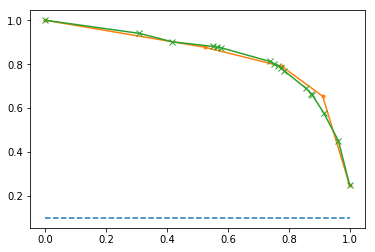

In [30]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
# fit a model
#model=linear_model.SGDClassifier( max_iter=5, random_state=42)
#model.fit(X_train, y_train)
#predicted = clf.predict(X_test)
#test_prediction_proba = clf.predict_proba(X_test)[:, 1]
    

model1 = KNeighborsClassifier(n_neighbors=3)
model2 = DecisionTreeClassifier(max_depth=4,random_state=42)
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
# predict probabilities
probs1 = model1.predict_proba(X_test)
probs2=model2.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs1 = probs1[:, 1]
probs2=probs2[:,1]
# predict class values
yhat1 = model1.predict(X_test)
yhat2 = model2.predict(X_test)
# calculate precision-recall curve
precision1, recall1, thresholds = precision_recall_curve(y_test, probs1)
precision2, recall2, thresholds = precision_recall_curve(y_test, probs2)

# calculate F1 score
f11 = f1_score(y_test, yhat1)
# calculate precision-recall AUC
auc1 = auc(recall1, precision1)
# calculate average precision score
ap1 = average_precision_score(y_test, probs1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f11, auc1, ap1))
# plot no skill
f12 = f1_score(y_test, yhat2)
# calculate precision-recall AUC
auc2 = auc(recall2, precision2)
# calculate average precision score
ap2 = average_precision_score(y_test, probs2)
print('f1=%.3f auc=%.3f ap=%.3f' % (f12, auc2, ap2))
# plot no skill
pyplot.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall1, precision1, marker='.')
pyplot.plot(recall2, precision2, marker='x')
# show the plot
pyplot.show()

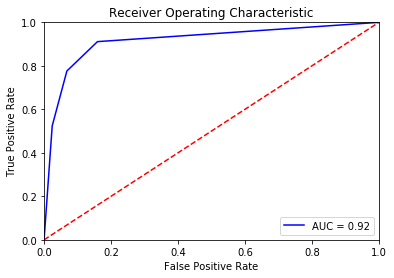

In [35]:
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
fpr, tpr, threshold = roc_curve(y_test, probs1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


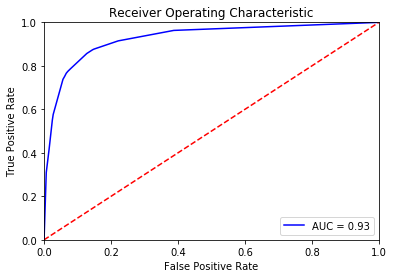

In [36]:
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
fpr, tpr, threshold = roc_curve(y_test, probs2)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

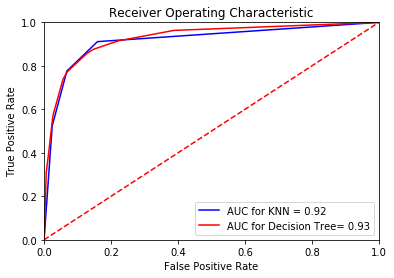

In [42]:
fpr1, tpr1, threshold = roc_curve(y_test, probs1)
fpr2, tpr2, threshold = roc_curve(y_test, probs2)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2= auc(fpr2,tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC for KNN = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'r', label = 'AUC for Decision Tree= %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## References
https://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list


https://wordnet.princeton.edu/documentation/morphy7wn